In [1]:
import os
import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from helpers import get_files_in_dir
from torchvision.io import read_image




In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
# to 10x10x10
# nn.Conv2d(3, 10, 10, stride=10, padding=0)

# to 10x9x9
# nn.Conv2d(3, 10, 15, stride=10, padding=0)
from helpers import draw_random_triangle
triangle = draw_random_triangle(128,(1,5))
# random tensor 3x32x32
triangle = torch.rand(1,3, 64, 64)
# from 3x100x100 to 3x20x20
c1 = nn.Conv2d(3, 8, 2, stride=2, padding=0)
#m1 = nn.Conv2d(8,3,1 ,stride=1, bias=False)

#triangle_tensor = torch.tensor(triangle).permute(2, 0, 1).unsqueeze(0).float()
triangle_tensor = triangle
triangle_tensor = c1(triangle_tensor)

print(triangle_tensor.shape)
print(triangle_tensor.flatten().shape)

# triangle_tensor = m1(triangle_tensor)
# print(triangle_tensor.shape)
# print(triangle_tensor.flatten().shape)


# # visualize
# triangle_tensor = triangle_tensor.squeeze(0)[0:3]
# triangle_tensor = triangle_tensor.permute(1, 2, 0)
# plt.imshow(triangle_tensor.detach().numpy())


torch.Size([1, 8, 32, 32])
torch.Size([8192])


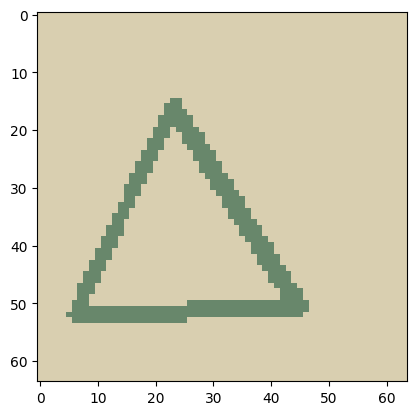

torch.Size([3, 64, 64])
torch.Size([3, 2, 64, 32])
torch.Size([3, 2, 2, 32, 32])
torch.Size([3, 4, 32, 32])


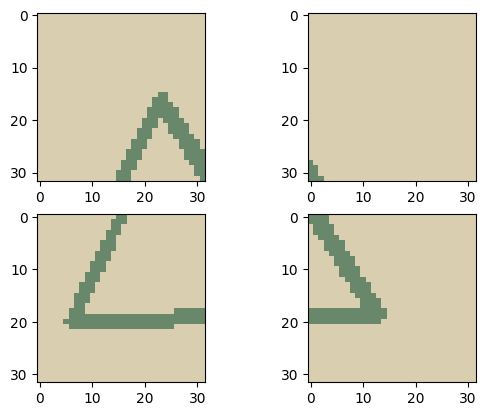

In [68]:
# random tensor of 5x3x64x64
# 5 images, 3 channels, 64x64
from helpers import draw_random_triangle
triangle = draw_random_triangle(64,(1,3))
# visualize triangle
plt.imshow(triangle)
plt.show()

random_tensor = torch.tensor(triangle).permute(2, 0, 1)
print(random_tensor.shape)
random_tensor = random_tensor.unfold(1, 32, 32)
print(random_tensor.shape)
random_tensor = random_tensor.unfold(2, 32, 32)
print(random_tensor.shape)
random_tensor = random_tensor.reshape(3,4,32,32)
print(random_tensor.shape) # 3x4x32x32



# visualize
random_tensor = random_tensor.permute(1,2,3,0)
chunk1 = random_tensor[0]
chunk2 = random_tensor[1]
chunk3 = random_tensor[2]
chunk4 = random_tensor[3]

# visualize all chunks in a grid
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(chunk1)
axs[0, 1].imshow(chunk2)
axs[1, 0].imshow(chunk3)
axs[1, 1].imshow(chunk4)
plt.show()




In [39]:
class tit(nn.Module):
    def __init__(self, patch_size = 32, classes = 5):
        super().__init__()
        
        # to 10x10x10
        # nn.Conv2d(3, 10, 10, stride=10, padding=0)

        # to 10x9x9
        # nn.Conv2d(3, 10, 15, stride=10, padding=0)
        
        # convolve original input
        # Bx3x124x124 -> Bx8x64x64

        self.patch_size = patch_size
        self.classes = classes
        self.patch_pipe = nn.Sequential(
            # B x 1 x patch_size x patch_size
            nn.Conv2d(3, 5, 2, stride=2, padding=0),
            # B x 5 x patch_size/2, patch_size/2
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(5*patch_size//2*patch_size//2, 5*patch_size//2*patch_size//2, bias=True),
            nn.ReLU(),
            nn.Linear(5*patch_size//2*patch_size//2, patch_size//2*patch_size//2, bias=True),
            nn.ReLU(),
            nn.Linear(patch_size//2*patch_size//2,patch_size//4*patch_size//4, bias=True),
            nn.LayerNorm(patch_size//4*patch_size//4),
            nn.ReLU(),
            # nn.Linear(patch_size//4*patch_size//4, self.classes**2, bias=True),
            # nn.ReLU(),
            # nn.Linear(self.classes**2,classes, bias=True),
        )

        self.combine_patches = nn.Sequential(
            nn.Linear(patch_size//4*patch_size//4, self.classes**2, bias=True),
            nn.ReLU(),
            nn.Linear(self.classes**2,classes, bias=True)
        )


    def split_into_patches(self,x, patch_size):
        # torch.Size([32, 3, 128, 128])
        # torch.Size([32, 3, 4, 4, 32, 32])
        #print(x.shape)
        x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        #print(x.shape)
        #print("to be: ", (x.shape[0], x.shape[1], x.shape[2] +x.shape[3], x.shape[4], x.shape[5]))
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2]*x.shape[3], x.shape[4], x.shape[5])
        # torch.Size([32, 3, 8, 32, 32])
        x = x.permute(0, 2, 1, 3, 4)
        return x

    def forward(self, x):
        #print("O CHUJ")
  

        patches = self.split_into_patches(x, self.patch_size)
        # zeros of shape patch_size//4*patch_size//4
        patch_sum = torch.zeros(patches.shape[0], self.patch_size//4*self.patch_size//4, device=device)
        # iterate over patches
        for i in range(patches.shape[1]):
            patch = patches[:,i,:,:].squeeze(1)
            patch = self.patch_pipe(patch)
            patch_sum += patch
            #print(patch.shape)
        
        return self.combine_patches(patch_sum)


In [22]:
from figures_dataset import FiguresData
train_dataset = FiguresData(128,1000, augment=True)
print("Training ponits: ",len(train_dataset))

valid_dataset = FiguresData(128,150)
print("Validation ponits: ",len(valid_dataset))


Training ponits:  1000
Validation ponits:  150


tensor(3)


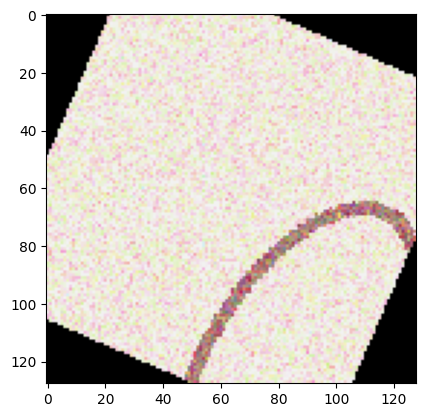

tensor(2)


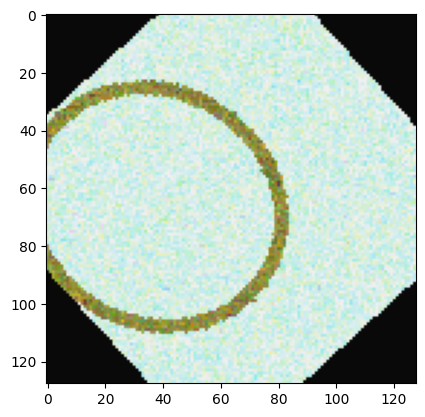

tensor(2)


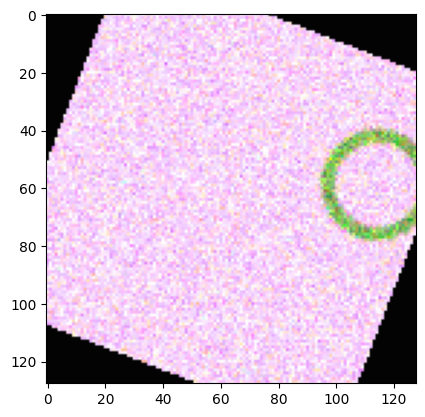

tensor(0)


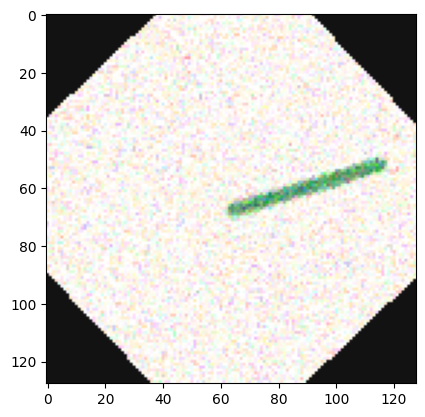

tensor(1)


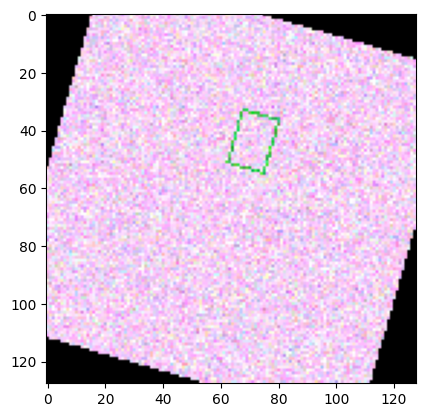

In [10]:
#terate training_set and visualize 
for i in range(5):
    print(train_dataset[i][1])
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.show()

In [37]:
# TRAINING IMPORTS
from torch import nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torcheval.metrics.functional import multiclass_accuracy
from torch.nn import CrossEntropyLoss

In [40]:
# TRAINING LOOP
model = tit()
model = model.to(device)
train_loader = DataLoader(train_dataset, batch_size=32)#, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)#, shuffle=True)

In [35]:
for i, batch in zip(range(len(train_loader)),train_loader):
    images, labels = batch
    model(images.to(device))
    break

O CHUJ
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 4, 4, 32, 32])
to be:  (32, 3, 8, 32, 32)
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 64])


In [41]:

ps = 0
for name, param in model.named_parameters():
    #print(f"Layer: {name} | Size: {param.size()} \n")
    param.requires_grad_ = True
    ps += param.numel()
    

epochs = 24

optimizer = optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5) #learning rate decay
criterion = CrossEntropyLoss()
iter_num = 0

lowest_loss = 999
valid_loss = 900
best_epoch = 0

epoch_pbar = tqdm(range(epochs))

print("Params to train: ",ps)

for epoch in epoch_pbar:
    print('Epoch num {}'.format(epoch))
    model.train()
    train_loss = 0

    #batch_pbar = enumerate(tqdm(train_loader))
    #for i,batch in batch_pbar:
    for i, batch in zip(range(len(train_loader)),train_loader):
        images, labels = batch
        images = images.to(torch.float32)
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)

        loss =  criterion(pred,labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item()
        iter_num+=1

    train_loss /= (i+1)

    if (epoch == 0) or (epoch > 4 and epoch % 5 == 0):
        model.eval()
        valid_loss = 0
        valid_accuracy = 0
        with torch.no_grad():
            for i, batch in zip(range(len(valid_loader)),valid_loader):
                images, labels = batch
                images = images.to(torch.float32)
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)

                loss =  criterion(pred,labels)
                valid_loss += loss.item()
                valid_accuracy += multiclass_accuracy(pred, labels)

        valid_loss /= (i+1)
        valid_accuracy /= (i+1)

            
        print('Validation loss {} | Validation accuracy {}'.format(round(valid_loss, 4), round(valid_accuracy.item(), 4)))

    print('Epoch num {}| train loss {} | lr_opt {} \n'.format(epoch,round(train_loss, 4),optimizer.param_groups[0]['lr']))

    if(epoch == 0):
        lowest_loss = valid_loss
    

    if (valid_loss + 0.01) < lowest_loss:
        lowest_loss = valid_loss
        best_epoch = epoch
        #print('New lowest loss: {} at epoch {}'.format(round(lowest_loss, 4), best_epoch))
    
    elif epoch>15 and epoch - best_epoch > 8:
        print('Early stopping at epoch {}. Best epoch: {} with score {} '.format(epoch, best_epoch, lowest_loss))
        break 

    
    scheduler.step()



  0%|          | 0/24 [00:00<?, ?it/s]

Params to train:  1986012
Epoch num 0
Validation loss 1.3879 | Validation accuracy 0.3352
Epoch num 0| train loss 2.5303 | lr_opt 0.01 

Epoch num 1
Epoch num 1| train loss 1.3941 | lr_opt 0.01 

Epoch num 2
Epoch num 2| train loss 1.3976 | lr_opt 0.01 

Epoch num 3
Epoch num 3| train loss 1.3923 | lr_opt 0.005 

Epoch num 4
Epoch num 4| train loss 1.3846 | lr_opt 0.005 

Epoch num 5
Validation loss 1.3896 | Validation accuracy 0.2273
Epoch num 5| train loss 1.3956 | lr_opt 0.005 

Epoch num 6
Epoch num 6| train loss 1.3891 | lr_opt 0.0025 

Epoch num 7
Epoch num 7| train loss 1.3873 | lr_opt 0.0025 

Epoch num 8
Epoch num 8| train loss 1.3909 | lr_opt 0.0025 

Epoch num 9
Epoch num 9| train loss 1.3862 | lr_opt 0.00125 

Epoch num 10
Validation loss 1.3879 | Validation accuracy 0.1989
Epoch num 10| train loss 1.3887 | lr_opt 0.00125 

Epoch num 11
Epoch num 11| train loss 1.3862 | lr_opt 0.00125 

Epoch num 12
Epoch num 12| train loss 1.3882 | lr_opt 0.000625 

Epoch num 13
Epoch num 

In [15]:
model.eval()
model.cpu()
del(model)

In [ ]:
crit = nn.CrossEntropyLoss()
dummy_pred = [0,0,0,0,0]
dummy_abel = 4
dummy_pred = torch.tensor(dummy_pred).float()
dummy_abel = torch.tensor(dummy_abel)
crit(dummy_pred,dummy_abel)

tensor(1.6094)

RuntimeError: Given normalized_shape=[605], expected input with shape [*, 605], but got input of size[5, 121]

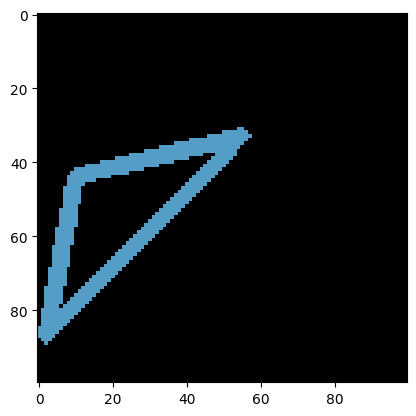

In [20]:
# make random triangle
from helpers import draw_random_triangle
crit = nn.CrossEntropyLoss()
model.cpu()
triangle1 = draw_random_triangle(100,(1,5))
# visualize triangle
plt.imshow(triangle)
# use model to predict triangle
triangle_tensor1 = torch.tensor(triangle1).permute(2, 0, 1).float()
# triangle2 = draw_random_triangle(100,(1,5))
# triangle_tensor2 = torch.tensor(triangle1).permute(2, 0, 1).float()

# # make mini-batch of triangles
# batch = torch.stack([triangle_tensor1,triangle_tensor2])
with torch.no_grad():    
    pred = model(triangle_tensor1)
    

print(pred)
# calculate loss
target = torch.tensor([4])
loss = crit(pred, target)
print(loss)

